Spline Compression Demo
=============
* Markus Michael Rau
* For questions please mail: markusmichael.rau@googlemail.com

This notebook describes how to compress pdfs using smoothing splines. The demo code should compress about 100M pdfs in <3 hours on new (2015) macbookpro using one core. If you find considerably worse performance (during compression) please contact the author.

Overview:
--------
* Please first **adjust your filepath** such that the notebook can find all the source files.
* We then load all necessary **packages and dependencies** 
* The notebook then demonstrates how to compress and store a PDF dataset. The code supports the usage of numpy datafiles and hdf5 files. 

Adjust your filepath
-------------------
**!!! NOTE !!! Perhaps you have to modify your working directory such that the notebook finds the source files. I adjusted the path names to fit my setup. Please adjust according to your computer.**


In [15]:
import sys
base_fname = '/Users/markusmichaelrau/Desktop/compression/'
#cd base_fname+'compression'
#Import path for the photoz-wg package
#sys.path.append(base_fname +'validation/')


<h2>Dependecies</h2>
In the follwoing we list the dependencies necessary to run the demo:
* numpy
* pandas

We first load in some dependencies and plotting styles

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import numpy as np
import time
from SparsePz.example_sparse import compress
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as spl
from numpy.random import randint
from SplineCompress import SplCompr
from utility import load_hdf5

# Figure formating
label_fontsize = 26
title_fontsize = 22
legend_fontsize = 14
tick_fontsize = 20
llinewidth = 2.5
ppointsize = 11
ccapsize = 12
eelinewidth = 4

Read in the Data
---------------
The following script illustrates how new datafiles are read in. The software supports two standard formats: hdf5 and numpy data array. We assume a Kernel Density Estimate (a smooth function) but histogramms will also work.  

* hdf5 files are the standard format used for instance in the validation script. The function load_hdf5 will be adapted to the standard format to be defined by the photoZ working group. Currently it simply reads in the simple test file 'Y1A1_MMRAU.hdf5'. 

* The columns of the numpy data array format should be ReshiftBins Density_PDF1 Density_PDF2 ... Density_PDFN
  
The following section illustrates how the different data files are read in and checks if both files contain the same data (as they should be by construction).



In [18]:
#Example HDF5 file
pdfFile_hd5 = base_fname+'Y1A1_MMRAU.hdf5'
data_hdf5 = load_hdf5(pdfFile_hd5)

#Example numpy data file
pdfFile_numpy = base_fname+'Y1A1_MMRAU.dat'
data_numpy = np.loadtxt(pdfFile_numpy)

#Check if both datafiles are consistent. This is just for illustration purposes
#to check if both files have been read in correctly.
#You do not have to read in a hdf5 file and a numpy array in practise.
if np.sum(data_hdf5 - data_numpy) == 0:
    print 'Read in ok'
    data = data_hdf5

print 'We generated redshift PDFs for %i objects sampled at %i points!' % (data.shape[1] - 1, data.shape[0])


Read in ok
We generated redshift PDFs for 13130 objects sampled at 300 points!


Setup the Spline Compression
--------------------------
The Spline compression depends on the definition of a equally spaced grid between the interpolation should be performed and a threshold which defines the lower limit for density values that are stored. This means we cut away all density points with a value below this threshold. This reduces the storage significantly since most PDF will be centered around a given redshift value and zero outside this region.

The SplCompr class which defines the spline compression must be defined with the parameters **zmin**, **zmax** which define the lower and upper edge of the equally spaced grid and **nnum** which defines how many step points should be placed between these values. The **thresh** parameter defines the cutting threshold.


In [19]:
#setup the spline compression
#input: redshift range, number of steppoints and cutting threshold
splcompr = SplCompr(zmin=0.0, zmax=1.5, nnum=35, thresh=0.001)

Compress the PDFs using Spline Interpolation and store the PDF in 
-------------------------------------------------------------
The following section takes the PDFs, compresses them and stores them. Compressing and storing the PDF is carried out by the class method store_pdf. 'Under the hook' we perform the following steps:
* We evaluate the PDF on the equally spaced grid
* We cut off all parts of the PDF with density above a predefined threshold 
* We store the start and end indices in 8 bit unsigned integers, the density values between as 16 bit floats
* For simplicity we generate two binary files of name PDFdemo and IDXdemo
* The generated files PDFdemo contains the density values, IDXdemo the indices 

In [20]:
print "Compressing the PDFs using Spline Compression"
t1 = time.time()
compressedY1A1 = splcompr.store_pdf(data, 'demo')
compr_time_spline = time.time() - t1
print 'Time taken: %f seconds, for %d objects'  % (compr_time_spline, data.shape[1] - 1)

Compressing the PDFs using Spline Compression
Your PDF has been stored!
Time taken: 1.141780 seconds, for 13130 objects


Read in the stored PDFs
---------------------
The following section reads in the compressed PDFs from the two files PDFdemo and IDXdemo using the function **read_pdf**. It uses the same name tag specified in the **store_pdf** routine.

In [21]:
print 'Your stored PDF files will be read in.'
t2 = time.time()
read_in_compressed = splcompr.read_pdf('demo')
print read_in_compressed
print "Time taken: %f seconds, for %d objects" % (time.time() - t2, data.shape[1] - 1)
num_floats = len(read_in_compressed[0])/(data.shape[1] - 1)
print 'Compress the PDF from %i points per object to %d 16 bit floats and 2 8 bit ints!' % (data.shape[0], num_floats)
print 'We therefore store %i 16 bit chuncks. For 100.000.000 objects we need to store %f gb.' % (num_floats + 1, 1E8*(num_floats + 1.0)*16/8e+9)


Your stored PDF files will be read in.
(array([  1.47056580e-03,   2.21061707e-03,   1.89361572e-02, ...,
         1.16825104e-05,   1.23262405e-04,   1.24645233e-03], dtype=float16), array([ 7, 30,  1, ..., 26,  1, 19], dtype=uint8))
Time taken: 0.003142 seconds, for 13130 objects
Compress the PDF from 300 points per object to 20 16 bit floats and 2 8 bit ints!
We therefore store 21 16 bit chuncks. For 100.000.000 objects we need to store 4.200000 gb.


Stack the PDFs and compare with the original:
------------------------------------------
The following section compares the compression accuracy of the spline compression with the original uncompressed PDFs. We stack the PDFs using the function **stack_pdf** that takes the output of the **read_pdf** routine and plot the results.

Stack the PDFs.
Time taken: 0.083688 seconds, for 13130 objects


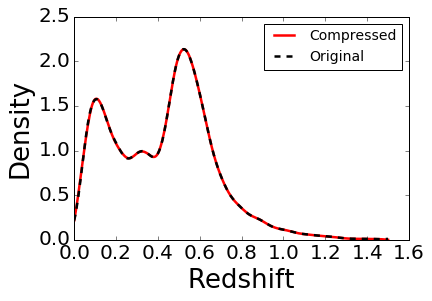

In [22]:
print 'Stack the PDFs.'
t3 = time.time()
#The PDF is stacked using the uncompressed PDFs
stacked_pdf = splcompr.stack_pdf(data[:, 0], read_in_compressed)
print "Time taken: %f seconds, for %d objects" % (time.time() - t3, data.shape[1] - 1)
plt.plot(stacked_pdf[:, 0], stacked_pdf[:, 1], label='Compressed', color='red',
         lw=llinewidth, ls='-')
plt.plot(data[:, 0], np.average(data[:, 1:], axis=1), color='black', label='Original',
        lw=llinewidth, ls='--')
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.legend(loc='upper right', fontsize=legend_fontsize)
plt.xlabel('Redshift', fontsize=label_fontsize)
plt.ylabel('Density', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.show()

Appendix
=====

In the appendix we present how one can stack many PDFs, perform stacking with and without weights and demonstrate the compression accuracy for a random photoZ PDF. Afterwards we compare the running time of the spline compression routine with Sparse representation. 

Stack PDFs
--------------
We stack PDFs using weights that are defined by the overlap of the individual PDF with a certain redshift interval. 
For each object we define it's weight in the interval $$[a, b]$$ as:
$$w_i^{\rm Bin} = \int_{a}^{b} p_i(z) dz$$

This allows us to obtain redshift PDFs that are weighted in predefined redshift bins. The interval border are specified as a list as the 'zrange' parameter.

Alternatively we can also pass auxillary weights  $$w_i^{\rm Aux}$$ defined by other means, for instance 'lensing weights'. These are be specified as the 'weights' parameter. 

Weigths defined by bin overlap $$w_i^{\rm Bin}$$ and auxillary weights $$w_i^{\rm Aux}$$ can be combined. This means we can specify lensing weights and bin in three redshift ranges. The weights for the redshift intervals are calculated and then multiplied by the lensing weights by the routine:
$$w_i = w_i^{\rm Aux} * w_i^{\rm Bin}$$

In the following we stack the compressed PDFs in three redshift bins (0.0, 0.5], (0.5, 1.0] and (1.0, 1.5] and compare with the uncompressed result.



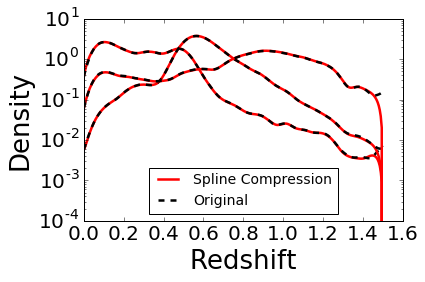

In [23]:
zbins=[[0.0, 0.5], [0.5, 1.0], [1.0, 1.5]]

stacked_b1 = splcompr.stack_pdf(data[:, 0], read_in_compressed, zrange=zbins[0])
stacked_b2 = splcompr.stack_pdf(data[:, 0], read_in_compressed, zrange=zbins[1])
stacked_b3 = splcompr.stack_pdf(data[:, 0], read_in_compressed, zrange=zbins[2])
true_b1_weights = splcompr.get_zrange_weights(data[:, 1:], zbins[0], data[:, 0])
true_b2_weights = splcompr.get_zrange_weights(data[:, 1:], zbins[1], data[:, 0])
true_b3_weights = splcompr.get_zrange_weights(data[:, 1:], zbins[2], data[:, 0])

plt.figure(3)

plt.plot(stacked_b1[:, 0], stacked_b1[:, 1], 'r', label='Spline Compression', lw=llinewidth, ls='-')
original_b1 = np.average(data[:, 1:], weights=true_b1_weights, axis=1)
plt.plot(data[:, 0], original_b1, 'k', label='Original', 
         lw=llinewidth, ls='--')

plt.plot(stacked_b2[:, 0], stacked_b2[:, 1], 'r', lw=llinewidth, ls='-')
original_b2 = np.average(data[:, 1:], weights=true_b2_weights, axis=1)
plt.plot(data[:, 0], original_b2, 'k', lw=llinewidth, ls='--')

plt.plot(stacked_b3[:, 0], stacked_b3[:, 1], 'r', lw=llinewidth, ls='-')
original_b3 = np.average(data[:, 1:], weights=true_b3_weights, axis=1)
plt.plot(data[:, 0], original_b3, 'k', lw=llinewidth, ls='--')

output_b1_orig = np.column_stack((data[:, 0], original_b1))
output_b2_orig = np.column_stack((data[:, 0], original_b2))
output_b3_orig = np.column_stack((data[:, 0], original_b3))

output_b1_spline = np.column_stack((stacked_b1[:, 0], stacked_b1[:, 1]))
output_b2_spline = np.column_stack((stacked_b2[:, 0], stacked_b2[:, 1]))
output_b3_spline = np.column_stack((stacked_b3[:, 0], stacked_b3[:, 1]))

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.legend(loc='lower center', fontsize=legend_fontsize)
plt.xlabel('Redshift', fontsize=label_fontsize)
plt.ylabel('Density', fontsize=label_fontsize)
plt.yscale('log')
plt.grid(False)
plt.tight_layout()
plt.show()

Compression of individual PDFs
----------------------------
The following section demonstrates the performance of the compression by plotting a random PDF compressed with spline compression and from the original uncompressed file. We evaluate the compressed PDF at the same redshift values as specified in the original data to demonstrate the accuracy of the compression. We also show how to explicitly uncompress the PDFs with the routine **uncompress** that is explicit in the functions discussed so far like stack_pdf.





Plot Object 12547


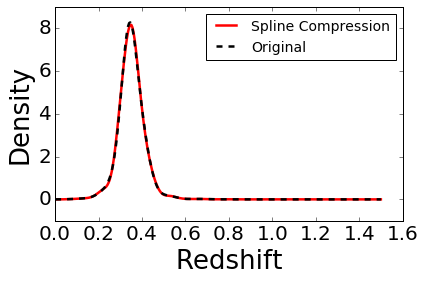

In [24]:
uncomp = splcompr.uncompress(*read_in_compressed)

i = randint(uncomp.shape[1])
print "Plot Object %i" % (i)
interpol = spl(splcompr.zlim, uncomp[:, i], ext=1)
plt.figure(1)
plt.plot(data[:, 0], interpol(data[:, 0]), color = 'r', label='Spline Compression', lw=llinewidth, 
         ls='-')
original_b1 = np.average(data[:, 1:], weights=true_b1_weights, axis=1)
plt.plot(data[:, 0], data[:, i+1], color='black', label='Original', lw=llinewidth,
         ls='--')
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.legend(loc='upper right', fontsize=legend_fontsize)
plt.xlabel('Redshift', fontsize=label_fontsize)
plt.ylabel('Density', fontsize=label_fontsize)
plt.grid(False)
plt.tight_layout()
plt.show()

Comparison with Sparse Representation
-----------------------------------
The following section compares the runtime of Spline compression with the runtime of sparse representation using the same dataset. We compress the same dataset with the Sparse Representation code and benchmark the running time.

In [27]:
print 'Compare this runtime with Sparse Representation:'
data_sparse = np.load('./SparsePz/y1a1_mmrau.npy')
print 'Beginning compressing with SparsePz'
tsparse = time.time()
compress(data_sparse, './SparsePz/y1a1_mmrau_compressed')
print 'Time taken: %f seconds, for %d objects'  % (time.time() - tsparse, data_sparse.shape[0] - 1)
print 'Spline compression took %f seconds for the same number of objects.' % (compr_time_spline)

Compare this runtime with Sparse Representation:
Beginning compressing with SparsePz
Total Galaxies =  13130
dz =  0.00501672240803
Nmu, Nsig, Nv =  [ 250 , 80 , 3 ]
Total bases in dictionary 60000
Creating Dictionary...
Nsparse (number of bases) =  20
0   13130  -------------> to core  0
Creating Sparse representation...


KeyboardInterrupt: 